In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

In [3]:
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 20

base_dir = "C:/Users/micha/Downloads/archive (2)/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Υπολογίζουμε τα βάρη για τις δύο κλάσεις
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4695 images belonging to 2 classes.
Class Weights: {0: np.float64(1.9449047224523612), 1: np.float64(0.6730217889908257)}
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

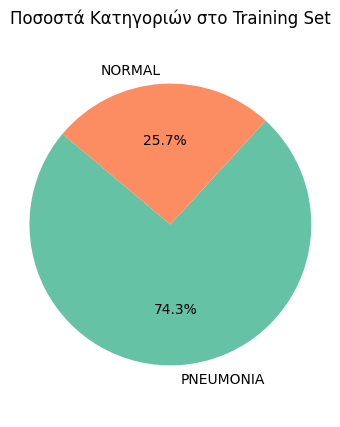

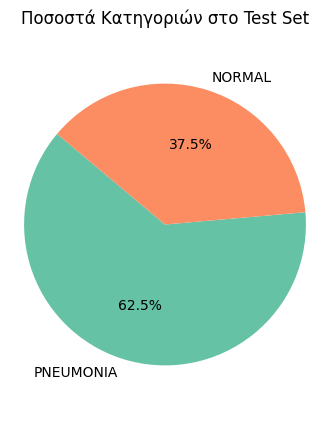

In [6]:
# Training set labels σε DataFrame
label_names_train = train_generator.class_indices
inv_map_train = {v: k for k, v in label_names_train.items()}
train_labels = train_generator.classes
df_train = pd.DataFrame({'label': [inv_map_train[i] for i in train_labels]})

# Pie chart για το training set
counts_train = df_train['label'].value_counts()
plt.figure(figsize=(4,5))
plt.pie(counts_train.values, labels=counts_train.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=140)
plt.title("Ποσοστά Κατηγοριών στο Training Set")
plt.axis('equal')
plt.show()

# Test set labels σε DataFrame
label_names_test = test_generator.class_indices
inv_map_test = {v: k for k, v in label_names_test.items()}
test_labels = test_generator.classes
df_test = pd.DataFrame({'label': [inv_map_test[i] for i in test_labels]})

# Pie chart για το test set
counts_test = df_test['label'].value_counts()
plt.figure(figsize=(4,5))
plt.pie(counts_test.values, labels=counts_test.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=140)
plt.title("Ποσοστά Κατηγοριών στο Test Set")
plt.axis('equal')
plt.show()

In [7]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 142s 950ms/step - accuracy: 0.5718 - loss: 0.6304 - val_accuracy: 0.7678 - val_loss: 0.5419 - learning_rate: 1.0000e-04
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 138s 936ms/step - accuracy: 0.8640 - loss: 0.3236 - val_accuracy: 0.9155 - val_loss: 0.2146 - learning_rate: 1.0000e-04
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 138s 938ms/step - accuracy: 0.9109 - loss: 0.2280 - val_accuracy: 0.8369 - val_loss: 0.4164 - learning_rate: 1.0000e-04
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 139s 944ms/step - accuracy: 0.9172 - loss: 0.2043 - val_accuracy: 0.9271 - val_loss: 0.1903 - learning_rate: 1.0000e-04
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 138s 935ms/step - accuracy: 0.9232 - loss: 0.1960 - val_accuracy: 0.9117 - val_loss: 0.2161 - learning_rate: 1.0000e-04
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9242 - loss: 0.2003
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
147/147 ━━━━━━━━━━━━━━━━━━━━ 149s 98

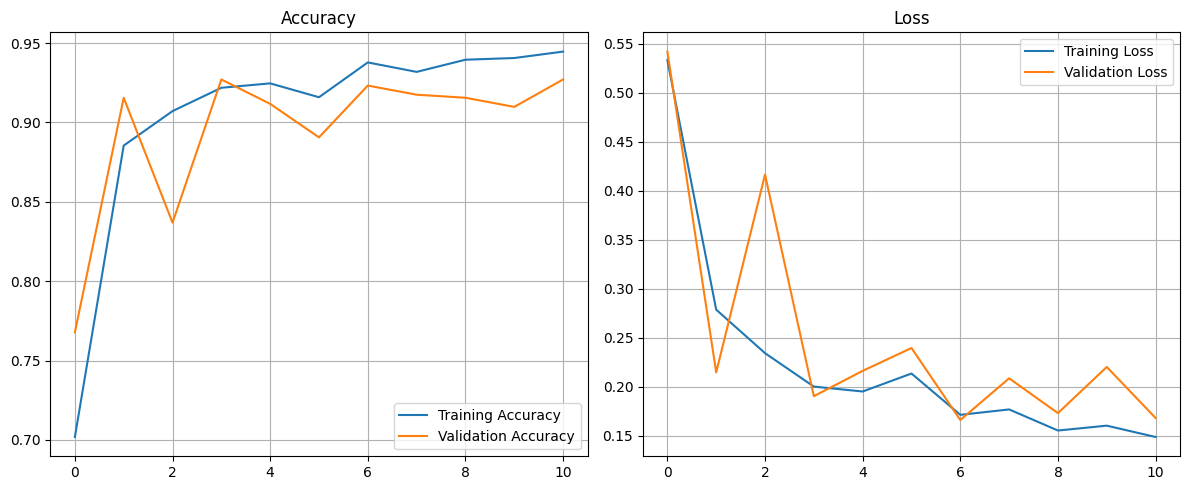

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step


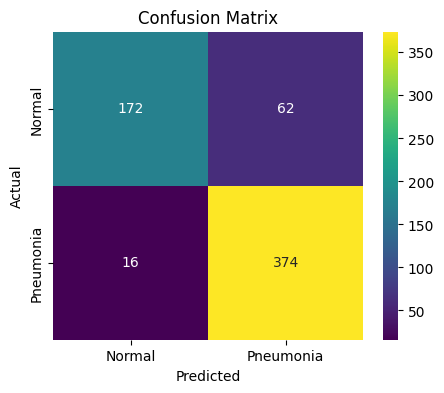

Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.74      0.82       234
   Pneumonia       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



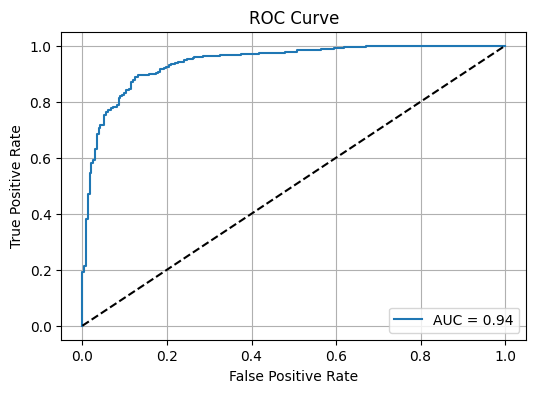

In [16]:
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_pred = (preds > 0.65).astype(int).reshape(-1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = roc_auc_score(y_true, preds)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()